## Import Python Module to Create/Upload New Data Instances
### (Persona: Data Engineer)

Use metaflow-based data model

In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import weave
from matplotlib import cm

In [2]:
s3 = s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']})

### Refresh provenance demo bucket

In [3]:
if s3.exists('provenance-demo'):
    s3.rm('s3://provenance-demo', recursive = True)
s3.mkdir("provenance-demo")

provenance_pantry = weave.Pantry(
    weave.IndexPandas,
    pantry_path="provenance-demo",
    file_system=s3,
)
provenance_index = provenance_pantry.index

provenance_pantry.upload_basket(
    upload_items=[{'path': '/home/jovyan/opal/resources/NASA_MILSTD1553_DTS.yaml', 'stub': False}],
    basket_type='NASA_MILSTD1553_DTS',
)

provenance_pantry.upload_basket(
    upload_items=[{'path': '/home/jovyan/opal/resources/NASA_ARINC429_DTS.yaml', 'stub': False}],
    basket_type='NASA_ARINC429_DTS',
)

provenance_pantry.upload_basket(
    upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': False}],
    basket_type='ch10',
    metadata = {'ch10name': '652200104150842'},
)["address"].iloc[0]

'provenance-demo/ch10/22b48990fb4611ee9c5b0242ac150011'

# What data do I have?

### Create an index of my data store using Weave.

<img src="resources/weave to minio.drawio.png">

In [4]:
# Create a pantry
basket_data_pantry = weave.Pantry(
    weave.IndexPandas,
    pantry_path="basket-data",
    file_system=s3,
)

# Ensure the index is up to date, then get the pandas df representation.
index = basket_data_pantry.index
index.generate_index()
index_df = index.to_pandas_df(max_rows=5000)
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,02f5c1d6093511eebd3c0242c0a82011,2023-06-12 15:22:58,[],NASA_ARINC429_DTS,,<0.13.0,basket-data/NASA_ARINC429_DTS/02f5c1d6093511ee...,S3FileSystem
1,14a09eec093511eebd3c0242c0a82011,2023-06-12 15:23:27,[],NASA_MILSTD1553_DTS,,<0.13.0,basket-data/NASA_MILSTD1553_DTS/14a09eec093511...,S3FileSystem
2,c4204bb09df011ee82e50242c0a8600b,2023-12-18 21:59:50.378564+00:00,[],airport_list,,1.4.0,basket-data/airport_list/c4204bb09df011ee82e50...,S3FileSystem
3,15dc7c12dca311eea0da0242ac15000d,2024-03-07 16:52:31.884109+00:00,[],ch10,652200101181702,1.6.3,basket-data/ch10/15dc7c12dca311eea0da0242ac15000d,S3FileSystem
4,1679ade8dca311ee9d610242ac15000d,2024-03-07 16:52:32.479564+00:00,[],ch10,22652200101181702,1.6.3,basket-data/ch10/1679ade8dca311ee9d610242ac15000d,S3FileSystem


In [5]:
print(f"Index length: {len(index)}")
index_df.basket_type.value_counts()

Index length: 863


basket_type
ch10_parsed                     127
ch10                            122
ch10_translated_ARINC429        118
ch10_translated_MILSTD1553      118
ch10_summary_v2                 113
ch10_translated_standardized    110
ch10_summary                    100
colocation_flights               30
colocation_event                 22
NASA_ARINC429_DTS                 1
NASA_MILSTD1553_DTS               1
airport_list                      1
Name: count, dtype: int64

# Where did my data come from?

### Provenance tracking example using Metaflow and TIP.

In [6]:
provenance_index_df = provenance_index.to_pandas_df()
provenance_index_df

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,22798b7efb4611ee9c5b0242ac150011,2024-04-15 16:35:14.005390+00:00,[],NASA_MILSTD1553_DTS,,1.7.2,provenance-demo/NASA_MILSTD1553_DTS/22798b7efb...,S3FileSystem
1,22989aa0fb4611ee9c5b0242ac150011,2024-04-15 16:35:14.208893+00:00,[],NASA_ARINC429_DTS,,1.7.2,provenance-demo/NASA_ARINC429_DTS/22989aa0fb46...,S3FileSystem
2,22b48990fb4611ee9c5b0242ac150011,2024-04-15 16:35:14.415527+00:00,[],ch10,,1.7.2,provenance-demo/ch10/22b48990fb4611ee9c5b0242a...,S3FileSystem


In [7]:
!python /home/jovyan/opal/data-engineering-resources/NASA_ch10_flows/parse_nasa_ch10s_flow.py --no-pylint run --bucket_name provenance-demo --n 1

Metaflow 2.11.4 executing NASAch10ParseFlow for user:jovyan
Validating your flow...
    The graph looks good!
2024-04-15 16:35:30.041 Workflow starting (run-id 1713198929863344):
2024-04-15 16:35:30.060 [1713198929863344/start/1 (pid 3415)] Task is starting.
2024-04-15 16:35:33.162 [1713198929863344/start/1 (pid 3415)] Task finished successfully.
2024-04-15 16:35:33.207 [1713198929863344/parse_ch10s/2 (pid 3454)] Task is starting.
2024-04-15 16:35:35.218 [1713198929863344/parse_ch10s/2 (pid 3454)] 1/1: provenance-demo/ch10/22b48990fb4611ee9c5b0242ac150011
2024-04-15 16:35:36.225 [1713198929863344/parse_ch10s/2 (pid 3454)] basket successfully parsed and uploaded: provenance-demo/ch10_parsed/2f988e7cfb4611ee87490242ac150011
2024-04-15 16:35:37.479 [1713198929863344/parse_ch10s/2 (pid 3454)] Task finished successfully.
2024-04-15 16:35:37.525 [1713198929863344/end/3 (pid 3499)] Task is starting.
2024-04-15 16:35:39.244 [1713198929863344/end/3 (pid 3499)] All Done
2024-04-15 16:35:44.064 [

In [8]:
provenance_index.generate_index()
provenance_index_df = provenance_index.to_pandas_df()
provenance_index_df

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,22989aa0fb4611ee9c5b0242ac150011,2024-04-15 16:35:14.208893+00:00,[],NASA_ARINC429_DTS,,1.7.2,provenance-demo/NASA_ARINC429_DTS/22989aa0fb46...,S3FileSystem
1,22798b7efb4611ee9c5b0242ac150011,2024-04-15 16:35:14.005390+00:00,[],NASA_MILSTD1553_DTS,,1.7.2,provenance-demo/NASA_MILSTD1553_DTS/22798b7efb...,S3FileSystem
2,22b48990fb4611ee9c5b0242ac150011,2024-04-15 16:35:14.415527+00:00,[],ch10,,1.7.2,provenance-demo/ch10/22b48990fb4611ee9c5b0242a...,S3FileSystem
3,2f988e7cfb4611ee87490242ac150011,2024-04-15 16:35:36.182610+00:00,[22b48990fb4611ee9c5b0242ac150011],ch10_parsed,652200104150842,1.7.2,provenance-demo/ch10_parsed/2f988e7cfb4611ee87...,S3FileSystem


In [9]:
!python /home/jovyan/opal/data-engineering-resources/NASA_ch10_flows/translate_nasa_ch10s_flow.py --no-pylint run --bucket_name provenance-demo --n 1
!python /home/jovyan/opal/data-engineering-resources/NASA_ch10_flows/translate_nasa_ch10s_flow.py --no-pylint run --bucket_name provenance-demo --data_type ARINC429 --n 1

Metaflow 2.11.4 executing NASAch10TranslateFlow for user:jovyan
Validating your flow...
    The graph looks good!
2024-04-15 16:35:47.364 Workflow starting (run-id 1713198947170578):
2024-04-15 16:35:47.378 [1713198947170578/start/1 (pid 3577)] Task is starting.
2024-04-15 16:35:50.381 [1713198947170578/start/1 (pid 3577)] Task finished successfully.
2024-04-15 16:35:50.452 [1713198947170578/get_dts_file/2 (pid 3619)] Task is starting.
2024-04-15 16:35:53.612 [1713198947170578/get_dts_file/2 (pid 3619)] Task finished successfully.
2024-04-15 16:35:53.682 [1713198947170578/translate_parsed/3 (pid 3664)] Task is starting.
2024-04-15 16:35:55.606 [1713198947170578/translate_parsed/3 (pid 3664)] -- translating 1 of 1: provenance-demo/ch10_parsed/2f988e7cfb4611ee87490242ac150011
2024-04-15 16:35:56.329 [1713198947170578/translate_parsed/3 (pid 3664)] basket successfully translated and uploaded:  provenance-demo/ch10_translated_MILSTD1553/3ba12404fb4611eea1e90242ac150011
2024-04-15 16:35:57.

In [10]:
provenance_index.generate_index()
provenance_index_df = provenance_index.to_pandas_df()
provenance_index_df

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,22989aa0fb4611ee9c5b0242ac150011,2024-04-15 16:35:14.208893+00:00,[],NASA_ARINC429_DTS,,1.7.2,provenance-demo/NASA_ARINC429_DTS/22989aa0fb46...,S3FileSystem
1,22798b7efb4611ee9c5b0242ac150011,2024-04-15 16:35:14.005390+00:00,[],NASA_MILSTD1553_DTS,,1.7.2,provenance-demo/NASA_MILSTD1553_DTS/22798b7efb...,S3FileSystem
2,22b48990fb4611ee9c5b0242ac150011,2024-04-15 16:35:14.415527+00:00,[],ch10,,1.7.2,provenance-demo/ch10/22b48990fb4611ee9c5b0242a...,S3FileSystem
3,2f988e7cfb4611ee87490242ac150011,2024-04-15 16:35:36.182610+00:00,[22b48990fb4611ee9c5b0242ac150011],ch10_parsed,652200104150842,1.7.2,provenance-demo/ch10_parsed/2f988e7cfb4611ee87...,S3FileSystem
4,47ac52d2fb4611ee9e020242ac150011,2024-04-15 16:36:17.066219+00:00,"[2f988e7cfb4611ee87490242ac150011, 22989aa0fb4...",ch10_translated_ARINC429,652200104150842,1.7.2,provenance-demo/ch10_translated_ARINC429/47ac5...,S3FileSystem
5,3ba12404fb4611eea1e90242ac150011,2024-04-15 16:35:56.277925+00:00,"[2f988e7cfb4611ee87490242ac150011, 22798b7efb4...",ch10_translated_MILSTD1553,652200104150842,1.7.2,provenance-demo/ch10_translated_MILSTD1553/3ba...,S3FileSystem


In [11]:
arinc_basket = provenance_index_df[provenance_index_df["basket_type"] == "ch10_translated_ARINC429"]
arinc_path = arinc_basket["address"].iloc[0]

arinc_metadata_path = os.path.join(arinc_path, 'basket_metadata.json')
with s3.open(arinc_metadata_path, 'rb') as file:
    arinc_metadata = json.load(file)
arinc_metadata

{'translate_metadata': {'type': 'translated_ARINC429_F0',
  'uid': '22c937a14e63cb4317d26e1667a0547f701a8bb3f0b75d875226ad2b6e549a2c',
  'provenance': {'time': '2024-04-15 16:36:15',
   'version': 'v3.0.3',
   'resource': [{'type': 'DTS_ARINC429_F0',
     'path': '/tmp/tmpb2uts3tx/local_dts_folder/NASA_ARINC429_DTS.yaml',
     'uid': '21f6e2e255ebd61662e9311b47cf6b915bd28d5d7e36d4f1f15e67182b2cd884'},
    {'type': 'parsed_ARINC429_F0',
     'path': '/tmp/tmpb2uts3tx/parsed_data.parquet/652200104150842_ARINC429_F0.parquet',
     'uid': 'f57336aaea29d6ed3d4d72cc7c69715b720c7fe22ec3b5093a3bdf57d90e4ad7'},
    {'type': 'CH10',
     'path': '/tmp/tmplqyeooit/652200104150842.ch10',
     'uid': '29b43ef8fe61d0077138f04b2570f6bc311255aa90ac6caedb07827ec2704c7c'}]},
  'config': {'translate_thread_count': 3,
   'use_tmats_busmap': False,
   'tmats_busname_corrections': {},
   'prompt_user': False,
   'vote_threshold': 1,
   'vote_method_checks_tmats': False,
   'bus_name_exclusions': [],
   'sto

### A look back at the complete index.

In [12]:
index_df

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,02f5c1d6093511eebd3c0242c0a82011,2023-06-12 15:22:58,[],NASA_ARINC429_DTS,,<0.13.0,basket-data/NASA_ARINC429_DTS/02f5c1d6093511ee...,S3FileSystem
1,14a09eec093511eebd3c0242c0a82011,2023-06-12 15:23:27,[],NASA_MILSTD1553_DTS,,<0.13.0,basket-data/NASA_MILSTD1553_DTS/14a09eec093511...,S3FileSystem
2,c4204bb09df011ee82e50242c0a8600b,2023-12-18 21:59:50.378564+00:00,[],airport_list,,1.4.0,basket-data/airport_list/c4204bb09df011ee82e50...,S3FileSystem
3,15dc7c12dca311eea0da0242ac15000d,2024-03-07 16:52:31.884109+00:00,[],ch10,652200101181702,1.6.3,basket-data/ch10/15dc7c12dca311eea0da0242ac15000d,S3FileSystem
4,1679ade8dca311ee9d610242ac15000d,2024-03-07 16:52:32.479564+00:00,[],ch10,22652200101181702,1.6.3,basket-data/ch10/1679ade8dca311ee9d610242ac15000d,S3FileSystem
...,...,...,...,...,...,...,...,...
858,b0321688e0a311ee81470242ac150014,2024-03-12 19:06:53.665669+00:00,[6d450b9a093111ee9c260242c0a82011],colocation_flights,,1.6.3,basket-data/colocation_flights/b0321688e0a311e...,S3FileSystem
859,b07a7bc6e0a311ee81470242ac150014,2024-03-12 19:06:54.137652+00:00,[6d450b9a093111ee9c260242c0a82011],colocation_flights,,1.6.3,basket-data/colocation_flights/b07a7bc6e0a311e...,S3FileSystem
860,b2d53848e0a311ee81470242ac150014,2024-03-12 19:06:58.107532+00:00,[6d450b9a093111ee9c260242c0a82011],colocation_flights,,1.6.3,basket-data/colocation_flights/b2d53848e0a311e...,S3FileSystem
861,b534597ae0a311ee81470242ac150014,2024-03-12 19:07:02.093208+00:00,[6d450b9a093111ee9c260242c0a82011],colocation_flights,,1.6.3,basket-data/colocation_flights/b534597ae0a311e...,S3FileSystem


<img src="./resources/ch10_flow.png"  width = "600" height="5500">

In [13]:
my_translated_data = index_df[index_df.basket_type == 'ch10_translated_MILSTD1553'].sample()
my_translated_data

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
658,620eca50093511eeba3d0242c0a82011,2023-06-12 15:25:37,"[b64749ce093211ee8e980242c0a82011, 14a09eec093...",ch10_translated_MILSTD1553,652200101241025,<0.13.0,basket-data/ch10_translated_MILSTD1553/620eca5...,S3FileSystem


In [14]:
my_parents = index_df[index_df.uuid.isin(my_translated_data.parent_uuids.iloc[0])]
my_parents

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
1,14a09eec093511eebd3c0242c0a82011,2023-06-12 15:23:27,[],NASA_MILSTD1553_DTS,,<0.13.0,basket-data/NASA_MILSTD1553_DTS/14a09eec093511...,S3FileSystem
210,b64749ce093211ee8e980242c0a82011,2023-06-12 15:06:30,[aaf85b2c093111ee9c260242c0a82011],ch10_parsed,652200101241025,<0.13.0,basket-data/ch10_parsed/b64749ce093211ee8e9802...,S3FileSystem


In [15]:
parsed_data = my_parents.iloc[1]
original_ch10 = index_df[index_df.uuid.isin(parsed_data.parent_uuids)]
original_ch10

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
86,aaf85b2c093111ee9c260242c0a82011,2023-06-12 14:59:04,[],ch10,652200101241025,<0.13.0,basket-data/ch10/aaf85b2c093111ee9c260242c0a82011,S3FileSystem


# How do I access my data?

### View a portion of the data contained in a ch10.

<img src="resources/weave to pandas.drawio.png">

In [16]:
my_data = index.get_baskets_of_label("652200101241025")
my_data

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
86,aaf85b2c093111ee9c260242c0a82011,2023-06-12 14:59:04,[],ch10,652200101241025,<0.13.0,basket-data/ch10/aaf85b2c093111ee9c260242c0a82011,S3FileSystem
210,b64749ce093211ee8e980242c0a82011,2023-06-12 15:06:30,[aaf85b2c093111ee9c260242c0a82011],ch10_parsed,652200101241025,<0.13.0,basket-data/ch10_parsed/b64749ce093211ee8e9802...,S3FileSystem
435,d888ddb8afef11eea6020242ac130009,2024-01-10 19:38:36.027442+00:00,"[620eca50093511eeba3d0242c0a82011, ed780e06093...",ch10_summary_v2,652200101241025,1.4.5,basket-data/ch10_summary_v2/d888ddb8afef11eea6...,S3FileSystem
572,ed780e06093711ee99f20242c0a82011,2023-06-12 15:43:51,"[b64749ce093211ee8e980242c0a82011, 02f5c1d6093...",ch10_translated_ARINC429,652200101241025,<0.13.0,basket-data/ch10_translated_ARINC429/ed780e060...,S3FileSystem
658,620eca50093511eeba3d0242c0a82011,2023-06-12 15:25:37,"[b64749ce093211ee8e980242c0a82011, 14a09eec093...",ch10_translated_MILSTD1553,652200101241025,<0.13.0,basket-data/ch10_translated_MILSTD1553/620eca5...,S3FileSystem
701,0076817eaa7611ee9ee50242c0a8800a,2024-01-03 20:23:48.721578+00:00,[620eca50093511eeba3d0242c0a82011],ch10_translated_standardized,652200101241025,1.4.2,basket-data/ch10_translated_standardized/00768...,S3FileSystem


In [17]:
path_1553 = os.path.join(my_data[my_data.basket_type == 'ch10_translated_MILSTD1553'].address.iloc[0], 'parsed_data_translated', 'NAV.parquet', '00.parquet')
df_1553 = pd.read_parquet(path_1553, filesystem = s3)
df_1553

,time,NAV-03,NAV-05,NAV-07,NAV-09,NAV-10,NAV-11,NAV-12,NAV-13,NAV-14,...,NAV-21,NAV-23,NAV-25,NAV-0110,NAV-0111,NAV-0112,NAV-0113,NAV-0114,NAV-0115,NAV-0116
0,980331880040000000,0.0,0.0,0.078663,-122.909546,-0.307617,0.494385,-122.909546,0.0,0.0,...,44.473517,-73.150743,372.0,True,True,True,False,True,True,True
1,980331880080000000,0.0,0.0,0.075165,-122.969971,-0.307617,0.494385,-122.969971,0.0,0.0,...,44.473517,-73.150743,372.0,True,True,True,False,True,True,True
2,980331880120000000,0.0,0.0,0.070499,-123.046875,-0.307617,0.494385,-123.046875,0.0,0.0,...,44.473517,-73.150743,372.0,True,True,True,False,True,True,True
3,980331880160000000,0.0,0.0,0.065830,-123.129272,-0.313110,0.499878,-123.129272,0.0,0.0,...,44.473517,-73.150743,372.0,True,True,True,False,True,True,True
4,980331880200000000,0.0,0.0,0.061165,-123.206177,-0.313110,0.499878,-123.206177,0.0,0.0,...,44.473517,-73.150743,372.0,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161295,980338331840000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,42.208960,-83.362021,420.0,True,True,True,False,True,True,True
161296,980338331880000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,42.208960,-83.362021,420.0,True,True,True,False,True,True,True
161297,980338331920000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,42.208960,-83.362021,420.0,True,True,True,False,True,True,True
161298,980338331960000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,42.208960,-83.362021,420.0,True,True,True,False,True,True,True


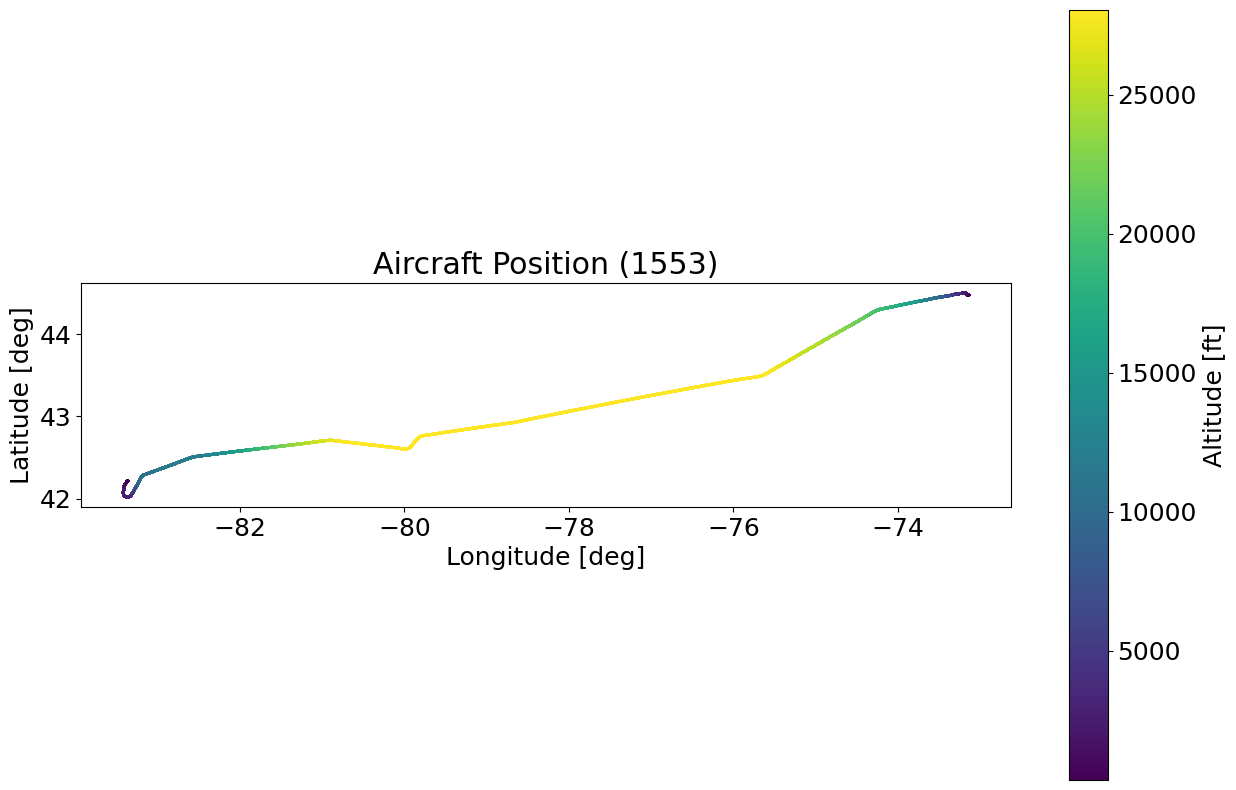

In [18]:
# Filter out invalid lat/long/altitude measurements
where_valid = df_1553[df_1553["NAV-0110"] & df_1553["NAV-0111"]]
plt.rcParams.update({"font.size":18})

# plot
fig, ax = plt.subplots()
ax = where_valid.plot(
    kind="scatter", title="Aircraft Position (1553)",
    x="NAV-23", y="NAV-21", c="NAV-25", s=1,
    cmap="viridis", figsize=(15, 10), ax=ax)

ax.set_aspect("equal")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
plt.gcf().get_axes()[1].set_ylabel("Altitude [ft]")
plt.show()

### Clear Bucket

In [19]:
if s3.exists('provenance-demo'):
    s3.rm('s3://provenance-demo', recursive = True)